"""
Alpaca API - MACD + stochastic strategy bactesting using Intraday KPIs

"""

In [1]:
import os
import json
from alpaca_trade_api.rest import REST, TimeFrame
from copy import deepcopy
import numpy as np
import pandas as pd

In [2]:
os.chdir("D:\\Python\\Alpaca_Keys") #change this based on the path on your local machine

endpoint = "https://data.alpaca.markets/v2"
headers = json.loads(open("keys.txt",'r').read())
tickers = ['FB','AMZN','INTC','MSFT','AAPL','GOOG','CSCO','CMCSA','ADBE',
           'NVDA','NFLX','PYPL','AMGN','AVGO','TXN','CHTR','QCOM','GILD',
           'FISV','BKNG','INTU','ADP','CME','TMUS','MU']

In [3]:
def hist_data(symbols, start_date ="2021-12-01", timeframe="Minute"):
    """
    returns historical bar data for a list of tickers e.g. symbols = ["MSFT,AMZN,GOOG"]
    """
    df_data = {}
    api = REST(headers["APCA-API-KEY-ID"], headers["APCA-API-SECRET-KEY"], base_url=endpoint)
    for ticker in symbols:
        if timeframe == "Minute":
            df_data[ticker] = api.get_bars(ticker, TimeFrame.Minute, start_date, adjustment='all').df
        elif timeframe == "Hour":
            df_data[ticker] = api.get_bars(ticker, TimeFrame.Hour, start_date, adjustment='all').df
        else:
            df_data[ticker] = api.get_bars(ticker, TimeFrame.Day, start_date, adjustment='all').df
    return df_data

In [4]:
def MACD(df_dict, a=12 ,b=26, c=9):
    """function to calculate MACD
       typical values a(fast moving average) = 12; 
                      b(slow moving average) =26; 
                      c(signal line ma window) =9"""
    for df in df_dict:
        df_dict[df]["ma_fast"] = df_dict[df]["close"].ewm(span=a, min_periods=a).mean()
        df_dict[df]["ma_slow"] = df_dict[df]["close"].ewm(span=b, min_periods=b).mean()
        df_dict[df]["macd"] = df_dict[df]["ma_fast"] - df_dict[df]["ma_slow"]
        df_dict[df]["signal"] = df_dict[df]["macd"].ewm(span=c, min_periods=c).mean()
        df_dict[df].drop(["ma_fast","ma_slow"], axis=1, inplace=True)

def stochastic(df_dict, lookback=14, k=3, d=3):
    """function to calculate Stochastic Oscillator
       lookback = lookback period
       k and d = moving average window for %K and %D"""
    for df in df_dict:
        df_dict[df]["HH"] = df_dict[df]["high"].rolling(lookback).max()
        df_dict[df]["LL"] = df_dict[df]["low"].rolling(lookback).min()
        df_dict[df]["%K"] = (100 * (df_dict[df]["close"] - df_dict[df]["LL"])/(df_dict[df]["HH"]-df_dict[df]["LL"])).rolling(k).mean()
        df_dict[df]["%D"] = df_dict[df]["%K"].rolling(d).mean()
        df_dict[df].drop(["HH","LL"], axis=1, inplace=True)
 

In [5]:
def winRate(DF):
    #"function to calculate win rate of intraday trading strategy"
    df = DF["return"]
    pos = df[df>1]
    neg = df[df<1]
    return (len(pos)/len(pos+neg))*100

def meanretpertrade(DF):
    df = DF["return"]
    df_temp = (df-1).dropna()
    return df_temp[df_temp!=0].mean()

def meanretwintrade(DF):
    df = DF["return"]
    df_temp = (df-1).dropna()
    return df_temp[df_temp>0].mean()

def meanretlostrade(DF):
    df = DF["return"]
    df_temp = (df-1).dropna()
    return df_temp[df_temp<0].mean()

def maxconsectvloss(DF):
    df = DF["return"]
    df_temp = df.dropna(axis=0)
    df_temp2 = np.where(df_temp<1,1,0)
    count_consecutive = []
    seek = 0
    for i in range(len(df_temp2)):
        if df_temp2[i] == 0:
            if seek > 0:
                count_consecutive.append(seek)
            seek = 0
        else:
            seek+=1
    if len(count_consecutive) > 0:
        return max(count_consecutive)
    else:
        return 0
    
def CAGR(DF):
    #"function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*26) #26 15-minute candles each trading day
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    #"function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*26)
    return vol

def sharpe(DF,rf):
    #"function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    #"function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [6]:
#extract and store historical data in dataframe
historicalData = hist_data(tickers, start_date ="2021-12-01", timeframe="Hour") 

Calculating daily returns for  FB
Calculating daily returns for  AMZN
Calculating daily returns for  INTC
Calculating daily returns for  MSFT
Calculating daily returns for  AAPL
Calculating daily returns for  GOOG
Calculating daily returns for  CSCO
Calculating daily returns for  CMCSA
Calculating daily returns for  ADBE
Calculating daily returns for  NVDA
Calculating daily returns for  NFLX
Calculating daily returns for  PYPL
Calculating daily returns for  AMGN
Calculating daily returns for  AVGO
Calculating daily returns for  TXN
Calculating daily returns for  CHTR
Calculating daily returns for  QCOM
Calculating daily returns for  GILD
Calculating daily returns for  FISV
Calculating daily returns for  BKNG
Calculating daily returns for  INTU
Calculating daily returns for  ADP
Calculating daily returns for  CME
Calculating daily returns for  TMUS
Calculating daily returns for  MU


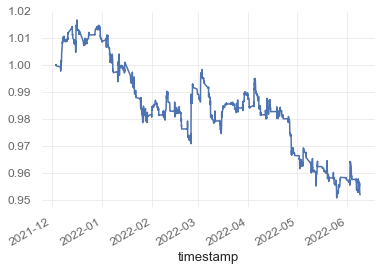

In [279]:
    
#####################################   BACKTESTING   ##################################
ohlc_dict = deepcopy(historicalData)
stoch_signal = {}
tickers_signal = {}
tickers_ret = {}
trade_count = {}
trade_data = {}
hwm = {}

MACD(ohlc_dict)
stochastic(ohlc_dict)

for ticker in tickers:
    ohlc_dict[ticker].dropna(inplace=True)
    stoch_signal[ticker] = ""
    tickers_signal[ticker] = ""
    trade_count[ticker] = 0
    hwm[ticker] = 0
    tickers_ret[ticker] = [0]
    trade_data[ticker] = {}

for ticker in tickers:
    print("Calculating daily returns for ",ticker)
    for i in range(1,len(ohlc_dict[ticker])-1):
        if ohlc_dict[ticker]["%K"][i] < 20:
            stoch_signal[ticker] = "oversold"
        elif ohlc_dict[ticker]["%K"][i] > 80:
            stoch_signal[ticker] = "overbought"
        
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["macd"][i]> ohlc_dict[ticker]["signal"][i] and \
               ohlc_dict[ticker]["macd"][i-1]< ohlc_dict[ticker]["signal"][i-1] and \
               stoch_signal[ticker]=="oversold":
                   tickers_signal[ticker] = "Buy"
                   trade_count[ticker]+=1
                   trade_data[ticker][trade_count[ticker]] = [ohlc_dict[ticker]["open"][i+1]]
                   hwm[ticker] = ohlc_dict[ticker]["open"][i+1]
                     
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["low"][i]<0.985*hwm[ticker]:
                tickers_signal[ticker] = ""
                trade_data[ticker][trade_count[ticker]].append(0.985*hwm[ticker])
                trade_count[ticker]+=1
                tickers_ret[ticker].append((0.985*hwm[ticker]/ohlc_dict[ticker]["close"][i-1])-1)
            else:
                hwm[ticker] = max(hwm[ticker],ohlc_dict[ticker]["high"][i])
                tickers_ret[ticker].append((ohlc_dict[ticker]["close"][i]/ohlc_dict[ticker]["close"][i-1])-1)
    
    if trade_count[ticker] % 2 != 0:
        trade_data[ticker][trade_count[ticker]].append(ohlc_dict[ticker]["close"][i+1])
        
    tickers_ret[ticker].append(0)
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])
    
    
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
    strategy_df[ticker].fillna(0, inplace=True)
strategy_df["ret"] = strategy_df.mean(axis=1)
    

CAGR(strategy_df)
sharpe(strategy_df, 0.03)
max_dd(strategy_df)

(1+strategy_df["ret"]).cumprod().plot() #plotting cumulative strategy return

#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}

for ticker in tickers:
    cagr[ticker] = CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.03)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])
    
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df = KPI_df.T

In [301]:
type(strategy_df['ret'].index)

pandas.core.indexes.datetimes.DatetimeIndex

In [302]:
import quantstats as qs

In [303]:
strategy_df.head()

,FB,AMZN,INTC,MSFT,AAPL,GOOG,CSCO,CMCSA,ADBE,NVDA,...,QCOM,GILD,FISV,BKNG,INTU,ADP,CME,TMUS,MU,ret
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-03 10:00:00+00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-12-03 11:00:00+00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-12-03 12:00:00+00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-12-03 13:00:00+00:00,0.0,0.0,0.0,0.004205,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000168
2021-12-03 14:00:00+00:00,0.0,0.0,0.0,-0.009791,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000392


In [304]:
type(strategy_df['ret'].index)

pandas.core.indexes.datetimes.DatetimeIndex

In [305]:
data_daily = strategy_df['ret']

In [306]:
strategy_df.index = pd.to_datetime(strategy_df.index)

# Set the 'timestamp' column as the index of the DataFrame
#strategy_df.set_index('timestamp', inplace=True)


In [307]:
strategy_df['ret']

timestamp
2021-12-03 10:00:00+00:00    0.000000
2021-12-03 11:00:00+00:00    0.000000
2021-12-03 12:00:00+00:00    0.000000
2021-12-03 13:00:00+00:00    0.000168
2021-12-03 14:00:00+00:00   -0.000392
                               ...   
2022-06-08 19:00:00+00:00   -0.000103
2022-06-08 20:00:00+00:00   -0.000041
2022-06-08 21:00:00+00:00    0.000013
2022-06-08 22:00:00+00:00   -0.000015
2022-06-08 23:00:00+00:00    0.000022
Name: ret, Length: 2106, dtype: float64

In [308]:
data_daily = strategy_df['ret'].resample('D').last()

In [309]:
#Convert the index to YYYY-MM-DD format
formatted_index = data_daily.index.strftime('%Y-%m-%d %H:00')

#Create a new Series with the formatted index
data_daily = pd.Series(data_daily.values, index=formatted_index)

In [310]:
data = data.fillna(method='ffill')

In [311]:
data_daily

timestamp
2021-12-03 00:00    0.000027
2021-12-04 00:00   -0.000089
2021-12-05 00:00         NaN
2021-12-06 00:00   -0.000013
2021-12-07 00:00    0.000043
                      ...   
2022-06-04 00:00         NaN
2022-06-05 00:00         NaN
2022-06-06 00:00    0.000000
2022-06-07 00:00   -0.001022
2022-06-08 00:00    0.000022
Length: 188, dtype: float64

In [312]:
#data_daily.index = pd.to_datetime(data_daily.index)

In [313]:
# Convert the values in the data_daily Series to numeric type
data_daily = pd.to_numeric(data_daily, errors='coerce')

# Remove NaN values from the data_daily Series
data_daily = data_daily.dropna()

In [314]:
data_daily

timestamp
2021-12-03 00:00    0.000027
2021-12-04 00:00   -0.000089
2021-12-06 00:00   -0.000013
2021-12-07 00:00    0.000043
2021-12-08 00:00   -0.000152
                      ...   
2022-06-02 00:00    0.000102
2022-06-03 00:00    0.000119
2022-06-06 00:00    0.000000
2022-06-07 00:00   -0.001022
2022-06-08 00:00    0.000022
Length: 144, dtype: float64

In [315]:
qs.reports.full(data_daily)

TypeError: unsupported operand type(s) for -: 'str' and 'str'